In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
import subprocess as sp
from scipy.stats.mstats import zscore

from scipy.stats import pearsonr, spearmanr

In [2]:
def enrichment_score(signal, exon_score=1):
    Nr = np.sum(signal)
    #exon_score = [1]*len(signal)
    denominator = len(signal) - np.sum(np.array(signal)>0)
    
    p_hit = []
    p_miss = []
    current_p_hit = 0
    current_p_miss = 0
    for i in range(len(signal)):
        if signal[i] > 0:
            current_p_hit += signal[i]/Nr
        else:
            current_p_miss += 1/denominator
        
        p_hit.append(current_p_hit)
        p_miss.append(current_p_miss)
        
    p_hit = np.array(p_hit)
    p_miss = np.array(p_miss)
    return p_hit-p_miss
    
def gsea(signal, permutations=2000):
    ES = np.max(enrichment_score(signal))
    ES_random = []
    for i in tqdm(range(permutations)):
        random_signal = np.random.choice(signal, len(signal), replace=False)
        ES_random.append(np.max(enrichment_score(random_signal)))
        
    ES_random = np.array(ES_random)
    p_val = (np.sum(ES_random >= ES)+1)/(permutations+1)
    return ES, p_val

def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched


def test_enrichment(binding, exon_cluster):
    M = len(binding)
    n = binding.sum()
    N = len(exon_cluster)
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def get_background(counts, manifold, n_neighbors=100, remove_self=True):
    
    gene_list = counts.index
    
    n_genes = len(gene_list)
    n_cells = len(psi.index)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    if remove_self:
        distances = distances[:,1:]
        indices = indices[:,1:]

    sigma_array = np.max(distances, axis=1)
    
    weights = np.exp(-(distances**2)/(sigma_array**2).reshape(len(counts.columns),1))
    
    smooth_gene = pd.DataFrame()
    
    print('slicing exons...')
    pandas_slices = []
    for idx in indices:
        pandas_slices.append(counts.loc[gene_list].T.iloc[idx].to_numpy())

    pandas_slices = np.array(pandas_slices)

    for i in tqdm(range(len(gene_list)), position=0, leave=True):
        gene = gene_list[i]

        
        neighbors_gene = pandas_slices[:,:,i]
        

        background = np.nansum(neighbors_gene*weights, axis=1)/((~np.isnan(np.array(neighbors_gene)))*weights).sum(axis=1)


        smooth_gene[gene] = background

    smooth_gene.index = counts.columns
    
    return smooth_gene
    


In [31]:
psix_results = pd.read_csv('psix_3D/psix_results.tab.gz', sep='\t', index_col=0)
modules = pd.read_csv('psix_object/modules_3D.tab.gz', sep='\t', index_col=0)
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)
psi =  pd.read_csv('data/preprocess/tables/psi_3D.tab.gz', sep='\t', index_col=0)
mrna_per_event =  pd.read_csv('data/preprocess/tables/mrna_per_event_3D.tab.gz', sep='\t', index_col=0)
neighbors_psi = pd.read_csv('data/preprocess/tables/neighbors_psi_3D.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)

from sklearn.preprocessing import StandardScaler
# scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_expression.T).T)
# scaled_counts.index = norm_expression.index
# scaled_counts.columns = norm_expression.columns

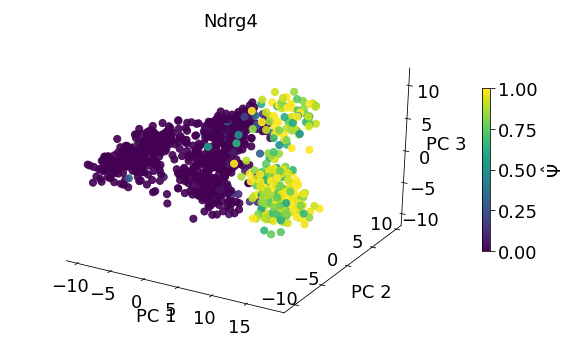

In [40]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=psi.loc['Ndrg4_1'], alpha=0.9, vmax=1, vmin=0, s=50)

cb = plt.colorbar(sc, shrink = 0.5)#, aspect=1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)

ax.grid(False)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=18, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=18, length=5, direction="in", pad=-22)
ax.set_title('Ndrg4', fontsize=18)
ax.set_xlabel('PC 1', fontsize=18)
ax.set_ylabel('PC 2', fontsize=18)
ax.set_zlabel('PC 3', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

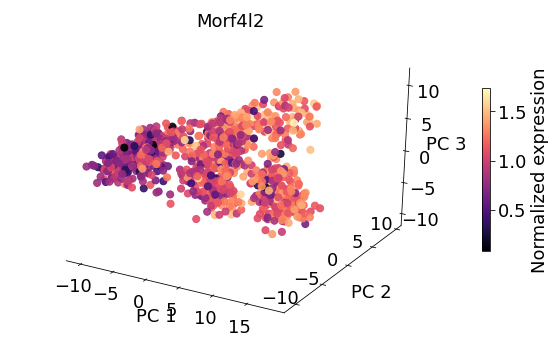

In [37]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=np.log10(mrna_per_event.loc['Morf4l2_7', latent.index]+1), 
                alpha=0.9, cmap='magma', s=50)

cb = plt.colorbar(sc, shrink = 0.5)#, aspect=1)
cb.set_label(label='Normalized expression',size=18)
cb.ax.tick_params(labelsize=18, length=5)

ax.grid(False)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=18, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=18, length=5, direction="in", pad=-22)
ax.set_title('Morf4l2', fontsize=18)
ax.set_xlabel('PC 1', fontsize=18)
ax.set_ylabel('PC 2', fontsize=18)
ax.set_zlabel('PC 3', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

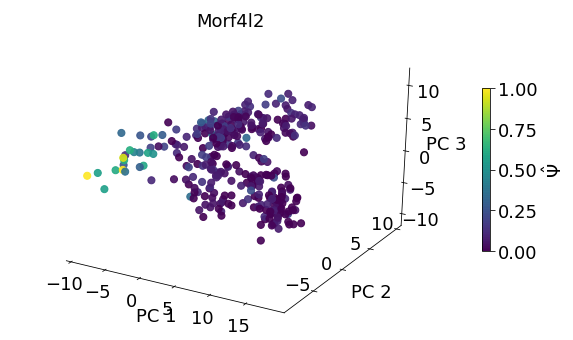

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=psi.loc['Morf4l2_7'].mask(mrna_per_event.loc['Morf4l2_7']<=15), 
                alpha=0.9, vmax=1, vmin=0, s=50)

cb = plt.colorbar(sc, shrink = 0.5)#, aspect=1)
cb.set_label(label='$\hat{\Psi}$',size=18)
cb.ax.tick_params(labelsize=18, length=5)

ax.grid(False)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=18, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=18, length=5, direction="in", pad=-22)
ax.set_title('Morf4l2', fontsize=18)
ax.set_xlabel('PC 1', fontsize=18)
ax.set_ylabel('PC 2', fontsize=18)
ax.set_zlabel('PC 3', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

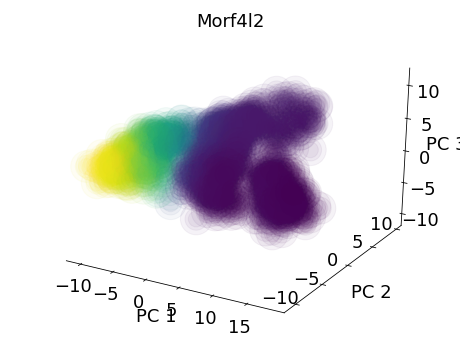

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=neighbors_psi.loc['Morf4l2_7'], s=1000, alpha=0.05)
ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=neighbors_psi.loc['Morf4l2_7'], s=500, alpha=0.05)
ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=neighbors_psi.loc['Morf4l2_7'], s=250, alpha=0.05)
# ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=neighbors_psi.loc['Morf4l2_7'], s=10, alpha=0.2)
# ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=neighbors_psi.loc['Morf4l2_7'], s=50, alpha=0.2)

ax.grid(False)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=18, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=18, length=5, direction="in", pad=-22)
ax.set_title('Morf4l2', fontsize=18)
ax.set_xlabel('PC 1', fontsize=18)
ax.set_ylabel('PC 2', fontsize=18)
ax.set_zlabel('PC 3', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)



ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

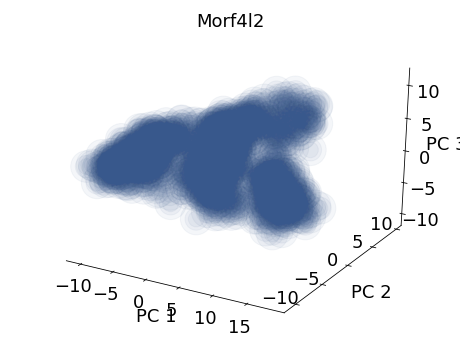

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=[psi.loc['Morf4l2_7'].mean()]*1067, s=1000, alpha=0.05, vmin=0, vmax=1)
ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=[psi.loc['Morf4l2_7'].mean()]*1067, s=500, alpha=0.05, vmin=0, vmax=1)
ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=[psi.loc['Morf4l2_7'].mean()]*1067, s=250, alpha=0.05, vmin=0, vmax=1)
# ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=neighbors_psi.loc['Morf4l2_7'], s=10, alpha=0.2)
# ax.scatter(latent.PC_1, latent.PC_2, latent.PC_3, c=neighbors_psi.loc['Morf4l2_7'], s=50, alpha=0.2)

ax.grid(False)
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(labelsize=18, length=5)#, direction="in", pad=-22)
ax.tick_params(axis='y',labelsize=18, length=5, direction="in", pad=-22)
ax.set_title('Morf4l2', fontsize=18)
ax.set_xlabel('PC 1', fontsize=18)
ax.set_ylabel('PC 2', fontsize=18)
ax.set_zlabel('PC 3', fontsize=18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.show()

In [39]:
[x for x in psix_results.index if 'Ndrg' in x]

['Ndrg4_1', 'Ndrg2_2', 'Ndrg3_6', 'Ndrg3_2']

In [4]:
clip_dir = '../rbp_binding/'
mouse_clip_overlap = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab.gz', sep='\t', index_col=0)
exon_length = pd.read_csv(clip_dir + 'exon_lengths.tab.gz', sep='\t', index_col=0, names=['ase', 'length'])

mouse_clip_overlap = mouse_clip_overlap.divide(exon_length.length, axis=0)

(2087, 12)


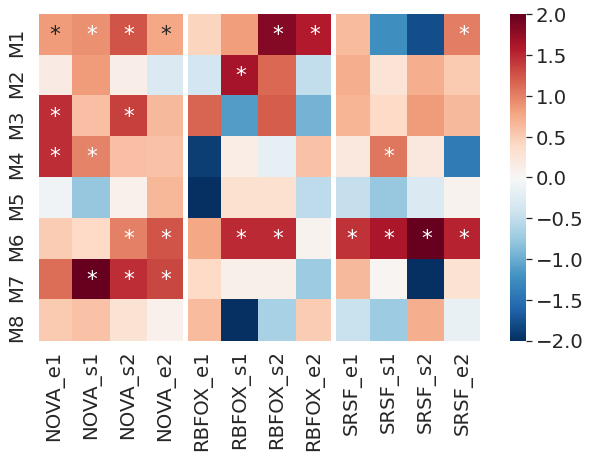

In [5]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_object/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]
# mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 9):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 9)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 9)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(8,-8)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [6]:
# mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)

e1 = [x for x in mouse_clip_peaks.index if '_e1' in x]
e2 = [x for x in mouse_clip_peaks.index if '_e2' in x]
s1 = [x for x in mouse_clip_peaks.index if '_s1' in x]
s2 = [x for x in mouse_clip_peaks.index if '_s2' in x]
idx = [x[:-3] for x in mouse_clip_peaks.index if '_e1' in x]
mouse_clip_peaks_e1 = mouse_clip_peaks.loc[e1]
mouse_clip_peaks_e2 = mouse_clip_peaks.loc[e2]
mouse_clip_peaks_s1 = mouse_clip_peaks.loc[s1]
mouse_clip_peaks_s2 = mouse_clip_peaks.loc[s2]

mouse_clip_peaks_e1.index = idx
mouse_clip_peaks_e2.index = idx
mouse_clip_peaks_s1.index = idx
mouse_clip_peaks_s2.index = idx

max_overlap= pd.concat([mouse_clip_peaks_e1, mouse_clip_peaks_s1, mouse_clip_peaks_s2, mouse_clip_peaks_e2]).max(level=0)
is_bound = mouse_clip_peaks_e1 + mouse_clip_peaks_e2 + mouse_clip_peaks_s1 + mouse_clip_peaks_s2

In [7]:
from numba import jit, njit

@njit
def enrichment_score(signal):
    
    Nr = 0
    for n in signal:
        if n < 0:
            Nr += -n
        else:
            Nr += n
#     Nr = np.sum(signal)
    
    suma = 0
    for s in signal:
        if s != 0:
            suma += 1
            
#     print(suma)
    
    missing = (len(signal) - suma)#np.sum(signal>0)
    denominator = missing
    
    p_hit = []
    p_miss = []
    current_p_hit = 0
    current_p_miss = 0
    for i in range(len(signal)):
        if signal[i] > 0:
            current_p_hit += signal[i]/Nr
        elif signal[i] < 0:
            current_p_hit += -signal[i]/Nr
        else:
            current_p_miss += 1/denominator
        
        p_hit.append(current_p_hit)
        p_miss.append(current_p_miss)
        
    pdiff = []
    for i in range(len(p_hit)):
        pdiff.append(p_hit[i]-p_miss[i])
        
    return pdiff#p_hit-p_miss
    
def gsea(signal, bound, permutations=1000):
    
    signal_bound = list(np.array(signal) * np.array((bound>0).astype(int)))
    
    ES = np.max(enrichment_score(signal_bound))
    ES_random = []
    for i in tqdm(range(permutations)):
        random_bound = np.random.choice(bound, len(signal), replace=False)
        
        random_signal = list(np.array(signal) * np.array((random_bound>0).astype(int)))
        
        ES_random.append(np.max(enrichment_score(random_signal)))
        
    ES_random = np.array(ES_random)
    p_val = (np.sum(ES_random >= ES)+1)/(permutations+1)
    return ES, p_val

In [8]:
es_pvals_list = []
p_pvals_list = []

es_score_list = []
p_score_list = []

es_rank_list = []
p_rank_list = []

for rbp in is_bound.columns:
    es, p = gsea(-np.log10(psix_results.pvals), is_bound.loc[psix_results.index][rbp])
    es_pvals_list.append(es)
    p_pvals_list.append(p)
    
    es, p = gsea(psix_results.psix_score, is_bound.loc[psix_results.index][rbp])
    es_score_list.append(es)
    p_score_list.append(p)
    
    es, p = gsea(np.ones(2087), is_bound.loc[psix_results.index][rbp])
    es_rank_list.append(es)
    p_rank_list.append(p)
    
    
    
enrichment_pvals = pd.DataFrame()
enrichment_pvals['ES'] = es_pvals_list
enrichment_pvals['pvals'] = p_pvals_list
enrichment_pvals.index = is_bound.columns

enrichment_score = pd.DataFrame()
enrichment_score['ES'] = es_score_list
enrichment_score['pvals'] = p_score_list
enrichment_score.index = is_bound.columns

enrichment_rank = pd.DataFrame()
enrichment_rank['ES'] = es_rank_list
enrichment_rank['pvals'] = p_rank_list
enrichment_rank.index = is_bound.columns

/mnt/lareaulab/cfbuenabadn/.local/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'signal' of function 'enrichment_score'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-7-61f34d40862c>", line 4:
@njit
def enrichment_score(signal):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
100%|██████████| 1000/1000 [00:07<00:00, 132.35it/s]


In [9]:
bound_exons = is_bound.columns[is_bound.loc[psix_results.index].sum() > 0].sort_values()

enrichment_pvals = enrichment_pvals.loc[bound_exons]
enrichment_score = enrichment_score.loc[bound_exons]
enrichment_rank = enrichment_rank.loc[bound_exons]

""
enrichment_pvals['qvals'] = multipletests(enrichment_pvals['pvals'], method='fdr_bh')[1]
enrichment_score['qvals'] = multipletests(enrichment_score['pvals'], method='fdr_bh')[1]
enrichment_rank['qvals'] = multipletests(enrichment_rank['pvals'], method='fdr_bh')[1]

In [30]:
enrichment_pvals.loc[enrichment_pvals.qvals <= 0.1].sort_index()

,ES,pvals,qvals
AGO2,0.516618,0.004995,0.010656
CELF4,0.603210,0.000999,0.003197
CIRBP,0.485902,0.000999,0.003197
FUS,0.478358,0.000999,0.003197
LIN28A,0.478390,0.002997,0.006850
MBNL1MBNL2,0.578008,0.014985,0.028207
MBNL2,0.730301,0.002997,0.006850
NOVA1,0.558331,0.000999,0.003197
NOVA2,0.574392,0.000999,0.003197
RBFOX1,0.633311,0.000999,0.003197


(2087, 12)


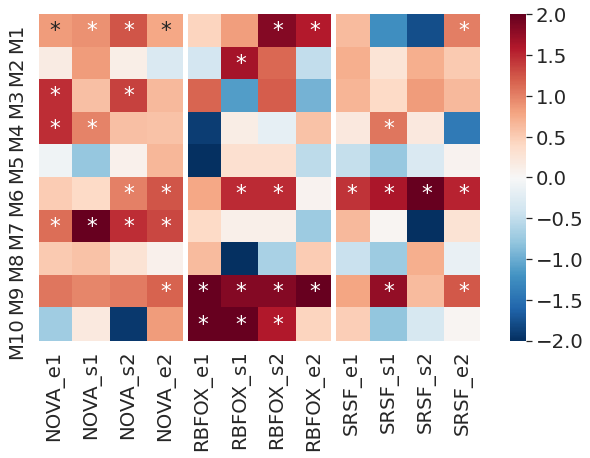

In [25]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4',  'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_object/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]
# mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

(2087, 44)


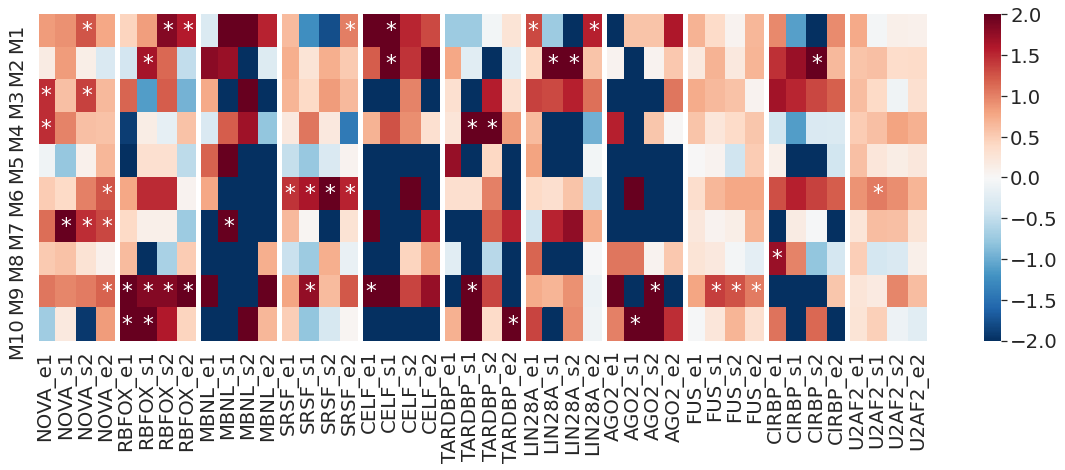

In [27]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
mouse_clip_families['MBNL_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
mouse_clip_families['MBNL_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))




mouse_clip_families['CELF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'CELF4'])
mouse_clip_families['CELF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'CELF4'])
mouse_clip_families['CELF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'CELF4'])
mouse_clip_families['CELF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'CELF4'])


mouse_clip_families['TARDBP_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'TARDBP'])
mouse_clip_families['TARDBP_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'TARDBP'])
mouse_clip_families['TARDBP_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'TARDBP'])
mouse_clip_families['TARDBP_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'TARDBP'])

mouse_clip_families['LIN28A_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'LIN28A'])
mouse_clip_families['LIN28A_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'LIN28A'])
mouse_clip_families['LIN28A_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'LIN28A'])
mouse_clip_families['LIN28A_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'LIN28A'])


mouse_clip_families['AGO2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'AGO2'])
mouse_clip_families['AGO2_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'AGO2'])
mouse_clip_families['AGO2_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'AGO2'])
mouse_clip_families['AGO2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'AGO2'])

mouse_clip_families['FUS_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'FUS'])
mouse_clip_families['FUS_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'FUS'])
mouse_clip_families['FUS_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'FUS'])
mouse_clip_families['FUS_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'FUS'])

mouse_clip_families['CIRBP_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'CIRBP'])
mouse_clip_families['CIRBP_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'CIRBP'])
mouse_clip_families['CIRBP_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'CIRBP'])
mouse_clip_families['CIRBP_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'CIRBP'])

mouse_clip_families['U2AF2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'U2AF2'])
mouse_clip_families['U2AF2_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'U2AF2'])
mouse_clip_families['U2AF2_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'U2AF2'])
mouse_clip_families['U2AF2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'U2AF2'])

# mouse_clip_families['EZH2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'EZH2'])
# mouse_clip_families['EZH2_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 'EZH2'])
# mouse_clip_families['EZH2_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 'EZH2'])
# mouse_clip_families['EZH2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'EZH2'])

mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_object/modules_3D.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]
# mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        #enrichment = test_enrichment(mouse_clip_families.loc[modules.index][rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if (labels.loc[exon, rbp]) and (np.abs(hyper_enrichment.loc[exon, rbp]>=1)):
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests


sns.set(font_scale=1.8)

fig = plt.figure(figsize=(20, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [43]:
module_avg = pd.DataFrame()

sf_list = ['Ago2', 'Celf4', 'Cirbp', 'Fus', 'Lin28a', 'Mbnl1', 'Mbnl2', 'Nova1', 'Nova2', 
           'Rbfox1', 'Rbfox2', 'Rbfox3', 'Srsf3', 'Srsf4', 'Srsf6', 'Srsf7', 'Tardbp', 'U2af2']

sf_list = [x for x in sf_list if x in norm_expression.index]

for mod in range(1, 11):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(sf_list), len(module_avg.index))), 
                               index = sf_list, columns = module_avg.index)
for sf in tqdm(sf_list):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
                                                norm_expression.loc[sf, module_avg.columns]
        )[0]
        
# module_avg_corr = pd.DataFrame(np.zeros((len(sf_neighbors.index), len(module_avg.index))), 
#                                index = sf_neighbors.index, columns = module_avg.index)
# for sf in tqdm(sf_neighbors.index):
#     for mod in module_avg.index:
#         module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod],
#                                                 norm_expression.loc[sf, module_avg.columns]
#         )[0]

100%|██████████| 17/17 [00:00<00:00, 56.91it/s]


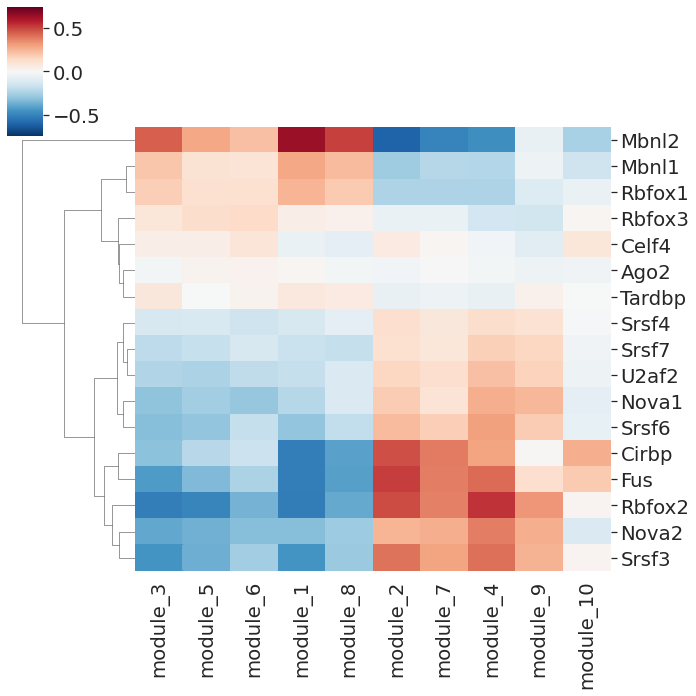

In [44]:
mod_order = ['module_3', 'module_5', 'module_6', 'module_1', 'module_8',
             'module_2', 'module_7', 'module_4', 'module_9', 'module_10']
sns.clustermap(module_avg_corr.loc[sf_list, mod_order], 
               col_cluster=False,
#               row_colors = gene_mod_colors, 
               row_cluster=True, vmin=-0.75, vmax=0.75, cmap='RdBu_r')

# P90 cells

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in long_scalars


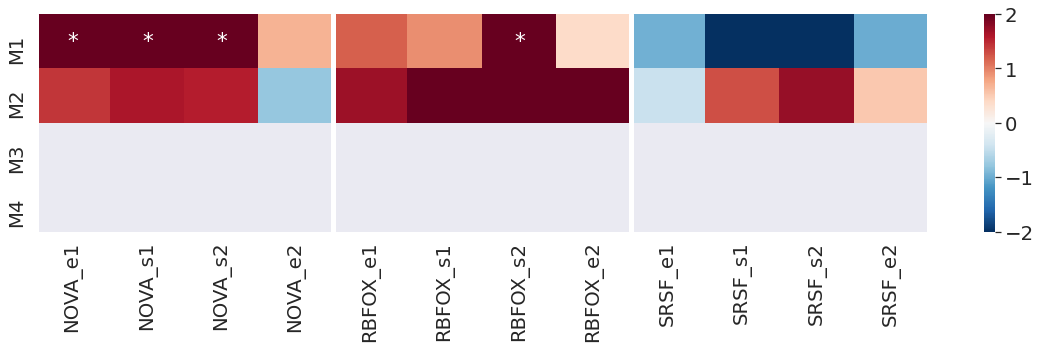

In [53]:
psix_results_p90 = pd.read_csv('psix_object_p90/psix_results.tab.gz', sep='\t', index_col=0)

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]



# mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = pd.read_csv('psix_object_p90/modules_p90.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results_p90.index & mouse_clip_families.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 5):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 5)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(4,-4)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(20, 4))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [52]:
np.sum((psix_results_p90.qvals <= 0.05) & (psix_results_p90.psix_score > 0))

77